In [1]:
import os 
import hydra
from omegaconf import DictConfig, OmegaConf
import sys
import torch
import numpy as np
from torch.utils.data import DataLoader

torch.backends.cudnn.benchmark = True

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

import matplotlib.pyplot as plt

In [2]:
from bayesian_dpddm import ConvModel, DPDDMBayesianMonitor
from experiments.utils import get_datasets, get_configs

In [3]:
RANDOM_SEED = 9927
np.random.seed(RANDOM_SEED)
torch.random.manual_seed(RANDOM_SEED)

### Get Hydra configs

In [4]:
config_dir = 'experiments/configs/'
config_name = 'cifar10'
hydra.initialize(config_path=config_dir, version_base='1.2')
cfg = hydra.compose(config_name=config_name)

In [5]:
cfg.from_pretrained = True

### Get configs

In [6]:
dataset =  get_datasets(cfg)
model_config, train_config = get_configs(cfg)

### Build model and monitor

In [7]:
base_model = ConvModel(model_config, train_size=len(dataset['train']))
monitor = DPDDMBayesianMonitor(
    model=base_model,
    trainset=dataset['train'],
    valset=dataset['valid'],
    train_cfg=train_config,
    device=device,
)

In [8]:
base_model.load_state_dict(torch.load(os.path.join('saved_weights', f'{cfg.dataset.name}.pth')))

<All keys matched successfully>

In [9]:
# sanity check trained performance
batch_size = 128
train_loader = DataLoader(dataset['train'], batch_size=batch_size)
val_loader = DataLoader(dataset['valid'], batch_size=batch_size)
test_loader = DataLoader(dataset['dpddm_id'], batch_size=batch_size)
ood_loader = DataLoader(dataset['dpddm_ood'], batch_size=batch_size)
loaders = [train_loader, val_loader, test_loader, ood_loader]
loaders_id = ['train', 'valid', 'test', 'ood']

In [10]:
for loader, loader_id in zip(loaders, loaders_id):
    accs = [] 
    monitor.model.eval()
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            output = monitor.model(images)
            probs = output.predictive.probs
            acc = monitor.eval_acc(probs, labels).item()
            accs.append(acc)
    print(f"Loader: {loader_id}, Accuracy: {np.mean(accs)}")

Loader: train, Accuracy: 0.865390375399361
Loader: valid, Accuracy: 0.8375197784810127
Loader: test, Accuracy: 0.8306962025316456
Loader: ood, Accuracy: 0.7216796875


In [11]:
args = cfg
monitor.pretrain_disagreement_distribution(dataset=dataset['dpddm_train'],
                                               n_post_samples=args.dpddm.n_post_samples,
                                               data_sample_size=500,
                                               Phi_size=args.dpddm.Phi_size, 
                                               temperature=10,
                                               )

 23%|██▎       | 114/500 [00:16<00:54,  7.11it/s]


KeyboardInterrupt: 

In [ ]:
rate, max_dis_rates = monitor.repeat_tests(n_repeats=args.dpddm.n_repeats,
                                      dataset=dataset['dpddm_train'], 
                                      n_post_samples=args.dpddm.n_post_samples,
                                      data_sample_size=50,
                                      temperature=10
                                      )
rate

100%|██████████| 100/100 [00:01<00:00, 81.47it/s]


np.float64(0.98)

(array([ 2.,  7., 26., 26.,  0., 17., 14.,  7.,  0.,  1.]),
 array([0.08      , 0.096     , 0.112     , 0.128     , 0.144     ,
        0.16      , 0.176     , 0.192     , 0.208     , 0.22399999,
        0.23999999]),
 <BarContainer object of 10 artists>)

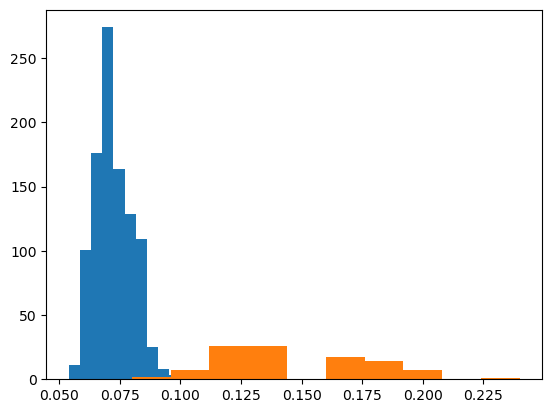

In [ ]:
plt.hist(monitor.Phi)
plt.hist(max_dis_rates)

### Investigate behavior

In [93]:
from bayesian_dpddm.monitors.utils import sample_from_dataset, temperature_scaling
import torch.nn.functional as F
X, y = sample_from_dataset(dataset=dataset['dpddm_train'], n_samples=100, replace=True)
y_pseudo = monitor.get_pseudolabels(X)
print(torch.sum(y.to(device) == y_pseudo)/len(y_pseudo))

tensor(0.8500, device='cuda:0')


### Get max disagreement rates

In [94]:
X, y_pseudo = X.to(device), y_pseudo.to(device)

In [105]:
temp = 1

In [106]:
model = monitor.model
with torch.no_grad():
    output = model.get_features(X)
    ll_dist = model.out_layer.logit_predictive(output)
    ll_dist.loc = ll_dist.loc
    ll_dist.scale = ll_dist.scale

In [107]:
logits_samples = ll_dist.rsample(sample_shape=torch.Size([5000]))
logits_samples = temperature_scaling(logits_samples, temp)

In [108]:
dist = torch.distributions.Categorical(logits=logits_samples)
y_hat = dist.sample()

In [109]:
tmp = []
for i in range(5000):
    rate = (y_hat[i] != y_pseudo).float().mean().item()
    tmp.append(rate)
max(tmp)

0.2800000011920929

In [110]:
y_tile = torch.tile(y_pseudo, (5000, 1)).cuda()
y_tile.shape

torch.Size([5000, 100])

In [111]:
y_hat.shape

torch.Size([5000, 100])

In [112]:
dis_mat = (y_hat != y_tile)
dis_rate = dis_mat.sum(dim=-1)/len(y)
torch.max(dis_rate).item()

0.2800000011920929

In [113]:
dis_rate.shape

torch.Size([5000])

In [114]:
dis_rate

tensor([0.1700, 0.1600, 0.1600,  ..., 0.1900, 0.1500, 0.1800], device='cuda:0')

In [115]:
ll_dist

Normal(loc: torch.Size([100, 10]), scale: torch.Size([100, 10]))

In [116]:
ll_dist.scale

tensor([[1.0456, 1.1385, 0.8966, 0.8294, 0.6944, 0.6931, 1.0488, 0.5736, 1.1509,
         1.0840],
        [0.6187, 0.8241, 0.9640, 1.0311, 1.0410, 1.0718, 1.0056, 1.0603, 0.4203,
         0.7717],
        [2.0480, 2.3146, 1.5980, 0.5035, 1.4490, 0.8518, 1.3738, 1.6512, 2.1593,
         2.1676],
        [0.7446, 0.4925, 0.9979, 0.9567, 0.9915, 0.9522, 0.9558, 0.8848, 0.7108,
         0.3895],
        [4.1144, 0.5396, 4.5568, 4.6295, 4.5940, 4.5411, 4.3329, 4.5622, 3.2926,
         1.3016],
        [1.2600, 1.2357, 0.8931, 0.7486, 0.9267, 0.9764, 0.6367, 1.2011, 1.2369,
         1.2705],
        [3.0622, 4.1787, 5.4772, 5.6666, 5.8027, 5.8814, 5.4171, 5.8891, 0.6446,
         3.9505],
        [2.9098, 2.5881, 1.6841, 1.7148, 1.9675, 2.4209, 0.4680, 2.8712, 2.7352,
         2.8540],
        [0.9475, 1.5933, 0.4696, 1.0895, 0.8584, 1.0915, 0.8754, 1.2814, 1.5120,
         1.6446],
        [0.8730, 0.9582, 0.7635, 0.6031, 0.6203, 0.5729, 0.7834, 0.6145, 0.9320,
         0.9017],
        [0

In [117]:
ll_dist.scale ** 2

tensor([[ 1.0934,  1.2962,  0.8039,  0.6878,  0.4823,  0.4804,  1.1000,  0.3290,
          1.3247,  1.1751],
        [ 0.3828,  0.6791,  0.9293,  1.0632,  1.0837,  1.1488,  1.0113,  1.1243,
          0.1766,  0.5955],
        [ 4.1941,  5.3574,  2.5535,  0.2535,  2.0995,  0.7256,  1.8873,  2.7264,
          4.6627,  4.6985],
        [ 0.5544,  0.2426,  0.9957,  0.9153,  0.9831,  0.9067,  0.9135,  0.7829,
          0.5053,  0.1517],
        [16.9282,  0.2911, 20.7648, 21.4322, 21.1051, 20.6214, 18.7744, 20.8134,
         10.8414,  1.6941],
        [ 1.5877,  1.5271,  0.7976,  0.5604,  0.8587,  0.9534,  0.4054,  1.4425,
          1.5300,  1.6142],
        [ 9.3772, 17.4614, 29.9999, 32.1098, 33.6710, 34.5903, 29.3450, 34.6817,
          0.4156, 15.6064],
        [ 8.4669,  6.6981,  2.8361,  2.9405,  3.8711,  5.8608,  0.2190,  8.2439,
          7.4816,  8.1455],
        [ 0.8978,  2.5386,  0.2205,  1.1870,  0.7369,  1.1913,  0.7664,  1.6420,
          2.2860,  2.7047],
        [ 0.7622,  